In [1]:
import torch
import dgl
from openeye import oechem, oedepict, oegrapheme
import espaloma as esp
import math


Using backend: pytorch


In [2]:
# layer
layer = esp.nn.layers.dgl_legacy.gn("SAGEConv")

# representation
representation = esp.nn.Sequential(layer, config=[128, "relu", 128, "relu", 128, "relu"])
janossy_config = [128, "relu", 128, "relu", 128, "relu", 128, "relu"]
readout = esp.nn.readout.janossy.JanossyPooling(
    in_features=128, config=janossy_config,
    out_features={
            1: {"e": 1, "s": 1},
            2: {'log_coefficients': 2},
            3: {'log_coefficients': 2},
            4: {'k': 6},
    },
)

readout_improper = esp.nn.readout.janossy.JanossyPoolingImproper(
    in_features=128, config=janossy_config
)

class ExpCoeff(torch.nn.Module):
    def forward(self, g):
        g.nodes['n2'].data['coefficients'] = g.nodes['n2'].data['log_coefficients'].exp()
        g.nodes['n3'].data['coefficients'] = g.nodes['n3'].data['log_coefficients'].exp()
        g.nodes['n2'].data['k'], g.nodes['n2'].data['eq'] = esp.mm.functional.linear_mixture_to_original(
            g.nodes['n2'].data['coefficients'][:, 0][:, None],
            g.nodes['n2'].data['coefficients'][:, 1][:, None],
            1.5, 6.0,
        )

        g.nodes['n3'].data['k'], g.nodes['n3'].data['eq'] = esp.mm.functional.linear_mixture_to_original(
            g.nodes['n3'].data['coefficients'][:, 0][:, None],
            g.nodes['n3'].data['coefficients'][:, 1][:, None],
            0.0, math.pi
        )
        
        return g

class GetLoss(torch.nn.Module):
    def forward(self, g):
        return torch.nn.MSELoss()(
            g.nodes['g'].data['u'] - g.nodes['g'].data['u'].mean(),
            g.nodes['g'].data['u_ref'] - g.nodes['g'].data['u_ref'].mean(),
        )

net = torch.nn.Sequential(
        representation,
        readout,
        readout_improper,
        ExpCoeff(),
        esp.nn.readout.charge_equilibrium.ChargeEquilibrium(),
        # esp.mm.geometry.GeometryInGraph(),
        # esp.mm.energy.EnergyInGraph(terms=["n2", "n3", "n4", "n4_improper"]),
)

In [3]:
net.load_state_dict(
    torch.load(
        "everything_joint.th",
        map_location="cpu",
    )
)

<All keys matched successfully>

In [4]:
def get_mol(n=1):
    g = esp.Graph(
        "CC(=O)" + n * "NC(C)C(=O)" + "NC",
    )
    
    # g.mol.compute_partial_charges_am1bcc()
    # g.nodes['n1'].data['q'] = torch.tensor(g.mol.partial_charges.flatten())[:, None]
    return g

In [5]:
def get_pipetide_bond(g):
    elements = g.nodes['n1'].data['h0'][:, :100].argmax(dim=-1)
    bonds = g.nodes['n2'].data['idxs']
    bond_elements = elements[bonds]
    is_nc_bonds = torch.logical_and(
        bond_elements[:, 0] == 6,
        bond_elements[:, 1] == 7,
    )
    is_connected_to_co = g.homograph.in_degrees()[bonds[:, 0]] == 3
    is_ok = torch.logical_and(is_nc_bonds, is_connected_to_co)
    return torch.where(is_ok)[0]

In [6]:
def get_co_bond(g):
    elements = g.nodes['n1'].data['h0'][:, :100].argmax(dim=-1)
    bonds = g.nodes['n2'].data['idxs']
    bond_elements = elements[bonds]
    is_nc_bonds = torch.logical_and(
        bond_elements[:, 0] == 6,
        bond_elements[:, 1] == 8,
    )
    is_connected_to_co = g.homograph.in_degrees()[bonds[:, 0]] == 3
    is_ok = torch.logical_and(is_nc_bonds, is_connected_to_co)
    return torch.where(is_ok)[0]

In [7]:
class AtomPartialChargeArcFxn(oegrapheme.OESurfaceArcFxnBase):
    def __init__(self, colorg, g):
        oegrapheme.OESurfaceArcFxnBase.__init__(self)
        self.colorg = colorg
        self.g = g

    def __call__(self, image, arc):
        adisp = arc.GetAtomDisplay()
        if adisp is None or not adisp.IsVisible():
            return False

        atom = adisp.GetAtom()
        if atom is None:
            return False

        idx = atom.GetIdx()
        charge = self.g.nodes['n1'].data['q_hat'][idx].item()
        if charge == 0.0:
            return True
        color = self.colorg.GetColorAt(charge)

        pen = oedepict.OEPen()
        pen.SetForeColor(color)
        pen.SetLineWidth(2.0)

        center = arc.GetCenter()
        radius = arc.GetRadius()
        bAngle = arc.GetBgnAngle()
        eAngle = arc.GetEndAngle()

        edgeAngle = 5.0
        dir = oegrapheme.OEPatternDirection_Outside
        patternAngle = 10.0
        oegrapheme.OEDrawBrickRoadSurfaceArc(image, center, bAngle, eAngle, radius, pen,
                                             edgeAngle, dir, patternAngle)
        return True

    def CreateCopy(self):
        return AtomPartialChargeArcFxn(self.colorg, self.g).__disown__()

In [8]:
class GetAtomLabel(oedepict.OEDisplayAtomPropBase):
    def __init__(self, g):
        oedepict.OEDisplayAtomPropBase.__init__(self)
        self.g = g

    def __call__(self, atom):
        idx = atom.GetIdx()
        charge = self.g.nodes['n1'].data['q_hat'][idx].item()
        return "%.2f" % charge

    def CreateCopy(self):
        copy = GetAtomLabel(g=self.g)
        return copy.__disown__()

In [13]:
class GetBondEq(oedepict.OEDisplayBondPropBase):
    def __init__(self, g):
        oedepict.OEDisplayBondPropBase.__init__(self)
        self.g = g

    def __call__(self, bond):
        bond_idx = bond.GetIdx()
        eq = 0.529177 * g.heterograph.nodes['n2'].data['eq'].flatten()[bond_idx]
        return "%.2f" % eq

    def CreateCopy(self):
        copy = GetBondEq(g=self.g)
        return copy.__disown__()

In [14]:
g = get_mol(5)
print(g.mol)

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 34, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order

Molecule with name '' and SMILES '[H]C([H])([H])C(=O)N([H])C([H])(C(=O)N([H])C([H])(C(=O)N([H])C([H])(C(=O)N([H])C([H])(C(=O)N([H])C([H])(C(=O)N([H])C([H])([H])[H])C([H])([H])[H])C([H])([H])[H])C([H])([H])[H])C([H])([H])[H])C([H])([H])[H]'


In [15]:
for idx in range(1, 4):
    g = get_mol(idx)
    net(g.heterograph)
    opts = oedepict.OE2DMolDisplayOptions(idx*300, idx*300, oedepict.OEScale_AutoScale)
    mol = g.mol.to_openeye()
    oechem.OEMMFFAtomTypes(mol)
    oechem.OEMMFF94PartialCharges(mol)
    oedepict.OEPrepareDepiction(mol)
    oechem.OETriposAtomTypeNames(mol)
    opts.SetAtomPropertyFunctor(GetAtomLabel(g=g))
    # opts.SetBondPropertyFunctor(GetBondEq(g=g))
    # opts.SetBondPropLabelFont(oedepict.OEFont(oechem.OEDarkBlue))
    disp = oedepict.OE2DMolDisplay(mol, opts)
    coloranion = oechem.OEColorStop(-1.0, oechem.OEColor(oechem.OEDarkRed))
    colorcation = oechem.OEColorStop(+1.0, oechem.OEColor(oechem.OEDarkBlue))
    colorg = oechem.OELinearColorGradient(coloranion, colorcation)
    colorg.AddStop(oechem.OEColorStop(0.0, oechem.OEColor(oechem.OEWhite)))

    arcfxn = AtomPartialChargeArcFxn(colorg, g=g)

    for atom in mol.GetAtoms():
        oegrapheme.OESetSurfaceArcFxn(mol, atom, arcfxn)
    oegrapheme.OEDraw2DSurface(disp)
    oedepict.OERenderMolecule("charge_%s.png" % idx, disp)

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 14, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aro

In [16]:
for idx in range(1, 4):
    g = get_mol(idx)
    net(g.heterograph)
    opts = oedepict.OE2DMolDisplayOptions(idx*300, idx*300, oedepict.OEScale_AutoScale)
    mol = g.mol.to_openeye()
    oechem.OEMMFFAtomTypes(mol)
    oechem.OEMMFF94PartialCharges(mol)
    oedepict.OEPrepareDepiction(mol)
    oechem.OETriposAtomTypeNames(mol)
    # opts.SetAtomPropertyFunctor(GetAtomLabel(g=g))
    opts.SetBondPropertyFunctor(GetBondEq(g=g))
    opts.SetBondPropLabelFont(oedepict.OEFont(oechem.OEDarkBlue))
    disp = oedepict.OE2DMolDisplay(mol, opts)
    coloranion = oechem.OEColorStop(-1.0, oechem.OEColor(oechem.OEDarkRed))
    colorcation = oechem.OEColorStop(+1.0, oechem.OEColor(oechem.OEDarkBlue))
    colorg = oechem.OELinearColorGradient(coloranion, colorcation)
    colorg.AddStop(oechem.OEColorStop(0.0, oechem.OEColor(oechem.OEWhite)))

    #     arcfxn = AtomPartialChargeArcFxn(colorg)

    #     for atom in mol.GetAtoms():
    #         oegrapheme.OESetSurfaceArcFxn(mol, atom, arcfxn)
    # oegrapheme.OEDraw2DSurface(disp)
    oedepict.OERenderMolecule("bond_%s.png" % idx, disp)

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 14, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aro

In [17]:
ace_eqs = []
nme_eqs = []
c_eqs = []
aceo_eqs = []
co_eqs = []

for idx in range(1, 11):
    g = get_mol(idx)
    net(g.heterograph)
    bonds = get_pipetide_bond(g)
    lengths = g.nodes['n2'].data['eq'][bonds]
    nme_eqs.append(lengths[-1])
    ace_eqs.append(lengths[1])
    c_eqs.append(lengths[int(len(lengths) * 0.5)])
    
    bonds = get_co_bond(g)
    lengths = g.nodes['n2'].data['eq'][bonds]
    co_eqs.append(lengths[int(len(lengths) * 0.5)])
    aceo_eqs.append(lengths[0])
    
    



Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 14, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aro

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 44, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 59, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order

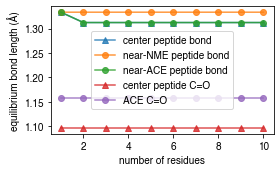

In [18]:
import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
from matplotlib import pyplot as plt
plt.figure(figsize=(4, 2.5))
plt.plot(np.arange(1, 11),0.529177 * np.array(c_eqs), '-^', label="center peptide bond", alpha=0.8)
plt.plot(np.arange(1, 11),0.529177 * np.array(nme_eqs), '-o', label="near-NME peptide bond", alpha=0.8)
plt.plot(np.arange(1, 11),0.529177 * np.array(ace_eqs), '-o', label="near-ACE peptide bond", alpha=0.8)

plt.plot(np.arange(1, 11),0.529177 * np.array(co_eqs), '-^', label="center peptide C=O", alpha=0.8)
plt.plot(np.arange(1, 11),0.529177 * np.array(aceo_eqs), '-o', label="ACE C=O", alpha=0.8)

plt.legend()
plt.xlabel("number of residues")
plt.ylabel("equilibrium bond length (Å)")
plt.tight_layout()
plt.savefig("bonds.png", dpi=300)

In [19]:
def get_nitrogen(g):
    elements = g.nodes['n1'].data['h0'][:, :100].argmax(dim=-1)
    is_ok = (elements == 7)
    return(torch.where(is_ok)[0])

def get_oxygen(g):
    elements = g.nodes['n1'].data['h0'][:, :100].argmax(dim=-1)
    is_ok = (elements == 8)
    return(torch.where(is_ok)[0])

In [20]:
cn_qs = []
nme_qs = []
co_qs = []
ace_qs = []
for idx in range(1, 11):
    g = get_mol(idx)
    net(g.heterograph)
    nitrogen_charges = g.nodes['n1'].data['q_hat'][get_nitrogen(g)]
    cn_q = nitrogen_charges[int(0.5 * len(nitrogen_charges))]
    nme_q = nitrogen_charges[-1]
    cn_qs.append(cn_q.item())
    nme_qs.append(cn_q.item())
    
    oxygen_charges = g.nodes['n1'].data['q_hat'][get_oxygen(g)]
    co_q = oxygen_charges[int(0.5 * len(oxygen_charges))]
    ace_q = oxygen_charges[0]
    co_qs.append(co_q.item())
    ace_qs.append(ace_q.item())


Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 14, aromatic: False, chiral: False

/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: dgl.to_homo is deprecated. Please use dgl.to_homogeneous
  retu

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 39, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 54, aromatic: False, chiral: False
Atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 8, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 11, aromatic: False, chiral: False
bond order

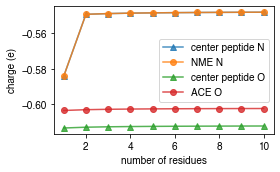

In [17]:
import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
from matplotlib import pyplot as plt
plt.figure(figsize=(4, 2.5))
plt.plot(np.arange(1, 11), np.array(cn_qs), '-^', label="center peptide N", alpha=0.8)
plt.plot(np.arange(1, 11),np.array(nme_qs), '-o', label="NME N", alpha=0.8)
plt.plot(np.arange(1, 11),np.array(co_qs), '-^', label="center peptide O", alpha=0.8)
plt.plot(np.arange(1, 11),np.array(ace_qs), '-o', label="ACE O", alpha=0.8)


plt.legend()
plt.xlabel("number of residues")
plt.ylabel("charge (e)")
plt.tight_layout()
plt.savefig("charges.png", dpi=300)

In [11]:
from simtk import openmm, unit
from simtk.openmm.app import Simulation, GBn2
from simtk.unit.quantity import Quantity

# simulation specs
TEMPERATURE = 300 * unit.kelvin
STEP_SIZE = 0.004 * unit.picoseconds
COLLISION_RATE = 1.0 / unit.picosecond
EPSILON_MIN = 0.05 * unit.kilojoules_per_mole 


In [12]:
def get_time(idx):
    import time
    g = get_mol(idx)
    net(g.heterograph)
    with torch.no_grad():
        time0 = time.time()
        net(g.heterograph)
        time1 = time.time()
    deployment_time = time1 - time0

    system = esp.graphs.deploy.openmm_system_from_graph(g, charge_method="nn")
    
    # use langevin integrator, although it's not super useful here
    integrator = openmm.LangevinIntegrator(
        TEMPERATURE, COLLISION_RATE, STEP_SIZE
    )

    # create simulation
    simulation = Simulation(
        topology=g.mol.to_topology().to_openmm(), 
        system=system,
        integrator=integrator,
        platform=openmm.Platform.getPlatformByName("Reference"),
    )

    simulation.context.setPositions(
        np.zeros((g.mol.n_atoms, 3)),
    )
    time0 = time.time()
    simulation.step(100000)
    time1 = time.time()

    energy_call_time = (time1 - time0) / 100000.0
    
    return deployment_time, energy_call_time

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
deploy_ts = []
run_ts = []
for idx in range(1, 100):
    print(idx)
    deploy_t, run_t = get_time(idx)
    print(deploy_t, run_t)
    deploy_ts.append(deploy_t)
    run_ts.append(run_t)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 4)



1


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 4)
 - Atom C (index 9)



0.01556396484375 4.44916820526123e-05
2


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 4)
 - Atom C (index 9)
 - Atom C (index 14)



0.01596689224243164 7.042832851409913e-05
3


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 4)
 - Atom C (index 9)
 - Atom C (index 14)
 - Atom C (index 19)



0.016892194747924805 0.00010110748767852783
4


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 4)
 - Atom C (index 9)
 - Atom C (index 14)
 - Atom C (index 19)
 - Atom C (index 24)



0.017546892166137695 0.00013498531103134156
5


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 4)
 - Atom C (index 9)
 - Atom C (index 14)
 - Atom C (index 19)
 - Atom C (index 24)
 - Atom C (index 29)



0.02006697654724121 0.00016799612045288086
6


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 4)
 - Atom C (index 9)
 - Atom C (index 14)
 - Atom C (index 19)
 - Atom C (index 24)
 - Atom C (index 29)
 - Atom C (index 34)



0.023009061813354492 0.00020081103086471558
7


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 4)
 - Atom C (index 9)
 - Atom C (index 14)
 - Atom C (index 19)
 - Atom C (index 24)
 - Atom C (index 29)
 - Atom C (index 34)
 - Atom C (index 39)



0.023838043212890625 0.0002347506284713745
8


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 4)
 - Atom C (index 9)
 - Atom C (index 14)
 - Atom C (index 19)
 - Atom C (index 24)
 - Atom C (index 29)
 - Atom C (index 34)
 - Atom C (index 39)
 - Atom C (index 44)



0.023222923278808594 0.00027419315814971923
9


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 4)
 - Atom C (index 9)
 - Atom C (index 14)
 - Atom C (index 19)
 - Atom C (index 24)
 - Atom C (index 29)
 - Atom C (index 34)
 - Atom C (index 39)
 - Atom C (index 44)
 - Atom C (index 49)



0.02649998664855957 0.00031514827013015746
10


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 4)
 - Atom C (index 9)
 - Atom C (index 14)
 - Atom C (index 19)
 - Atom C (index 24)
 - Atom C (index 29)
 - Atom C (index 34)
 - Atom C (index 39)
 - Atom C (index 44)
 - Atom C (index 49)
 - Atom C (index 54)



0.025878190994262695 0.00036012614250183103
11


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 4)
 - Atom C (index 9)
 - Atom C (index 14)
 - Atom C (index 19)
 - Atom C (index 24)
 - Atom C (index 29)
 - Atom C (index 34)
 - Atom C (index 39)
 - Atom C (index 44)
 - Atom C (index 49)
 - Atom C (index 54)
 - Atom C (index 59)



0.028549909591674805 0.00040150360107421877
12


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 4)
 - Atom C (index 9)
 - Atom C (index 14)
 - Atom C (index 19)
 - Atom C (index 24)
 - Atom C (index 29)
 - Atom C (index 34)
 - Atom C (index 39)
 - Atom C (index 44)
 - Atom C (index 49)
 - Atom C (index 54)
 - Atom C (index 59)
 - Atom C (index 64)



0.02930307388305664 0.0004550791597366333
13


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 4)
 - Atom C (index 9)
 - Atom C (index 14)
 - Atom C (index 19)
 - Atom C (index 24)
 - Atom C (index 29)
 - Atom C (index 34)
 - Atom C (index 39)
 - Atom C (index 44)
 - Atom C (index 49)
 - Atom C (index 54)
 - Atom C (index 59)
 - Atom C (index 64)
 - Atom C (index 69)



0.030379772186279297 0.0005093691802024841
14


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 4)
 - Atom C (index 9)
 - Atom C (index 14)
 - Atom C (index 19)
 - Atom C (index 24)
 - Atom C (index 29)
 - Atom C (index 34)
 - Atom C (index 39)
 - Atom C (index 44)
 - Atom C (index 49)
 - Atom C (index 54)
 - Atom C (index 59)
 - Atom C (index 64)
 - Atom C (index 69)
 - Atom C (index 74)



0.030851125717163086 0.0005680755090713501
15


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 4)
 - Atom C (index 9)
 - Atom C (index 14)
 - Atom C (index 19)
 - Atom C (index 24)
 - Atom C (index 29)
 - Atom C (index 34)
 - Atom C (index 39)
 - Atom C (index 44)
 - Atom C (index 49)
 - Atom C (index 54)
 - Atom C (index 59)
 - Atom C (index 64)
 - Atom C (index 69)
 - Atom C (index 74)
 - Atom C (index 79)



0.03382992744445801 0.0006147408509254456
16


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 4)
 - Atom C (index 9)
 - Atom C (index 14)
 - Atom C (index 19)
 - Atom C (index 24)
 - Atom C (index 29)
 - Atom C (index 34)
 - Atom C (index 39)
 - Atom C (index 44)
 - Atom C (index 49)
 - Atom C (index 54)
 - Atom C (index 59)
 - Atom C (index 64)
 - Atom C (index 69)
 - Atom C (index 74)
 - Atom C (index 79)
 - Atom C (index 84)



0.03346824645996094 0.0006823670601844787
17


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 4)
 - Atom C (index 9)
 - Atom C (index 14)
 - Atom C (index 19)
 - Atom C (index 24)
 - Atom C (index 29)
 - Atom C (index 34)
 - Atom C (index 39)
 - Atom C (index 44)
 - Atom C (index 49)
 - Atom C (index 54)
 - Atom C (index 59)
 - Atom C (index 64)
 - Atom C (index 69)
 - Atom C (index 74)
 - Atom C (index 79)
 - Atom C (index 84)
 - Atom C (index 89)



0.035410165786743164 0.0007338582611083985
18


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 4)
 - Atom C (index 9)
 - Atom C (index 14)
 - Atom C (index 19)
 - Atom C (index 24)
 - Atom C (index 29)
 - Atom C (index 34)
 - Atom C (index 39)
 - Atom C (index 44)
 - Atom C (index 49)
 - Atom C (index 54)
 - Atom C (index 59)
 - Atom C (index 64)
 - Atom C (index 69)
 - Atom C (index 74)
 - Atom C (index 79)
 - Atom C (index 84)
 - Atom C (index 89)
 - Atom C (index 94)



0.036187171936035156 0.0008142786574363708
19


Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 4)
 - Atom C (index 9)
 - Atom C (index 14)
 - Atom C (index 19)
 - Atom C (index 24)
 - Atom C (index 29)
 - Atom C (index 34)
 - Atom C (index 39)
 - Atom C (index 44)
 - Atom C (index 49)
 - Atom C (index 54)
 - Atom C (index 59)
 - Atom C (index 64)
 - Atom C (index 69)
 - Atom C (index 74)
 - Atom C (index 79)
 - Atom C (index 84)
 - Atom C (index 89)
 - Atom C (index 94)
 - Atom C (index 99)



0.036576032638549805 0.0009093170809745789
20


KeyboardInterrupt: 

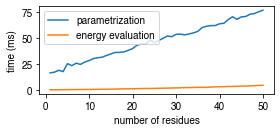

In [37]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
plt.figure(figsize=(4, 2))
plt.plot(np.arange(1, 51), 1000 * np.array(deploy_ts[:50]), '-', label="parametrization")
plt.plot(np.arange(1, 51), 1000 * np.array(run_ts[:50]), '-', label="energy evaluation")
plt.legend()
plt.xlabel("number of residues")
plt.ylabel("time (ms)")
plt.tight_layout()
plt.savefig("time.png", dpi=300)